## Data

In [1]:
from sklearn.datasets import make_circles
import torch

In [2]:
n_samples = 1000

X, y = make_circles(n_samples,
                    random_state=42,
                    noise=0.03)

X[:5], y[:5]

(array([[ 0.75424625,  0.23148074],
        [-0.75615888,  0.15325888],
        [-0.81539193,  0.17328203],
        [-0.39373073,  0.69288277],
        [ 0.44220765, -0.89672343]]),
 array([1, 1, 1, 1, 0]))

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
X.shape

(1000, 2)

In [5]:
import pandas as pd

In [6]:
df = pd.DataFrame({"X1": X[:, 0],
                   "X2": X[:, 1],
                   "label": y})

df.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


## Visualisation

In [7]:
import matplotlib.pyplot as plt

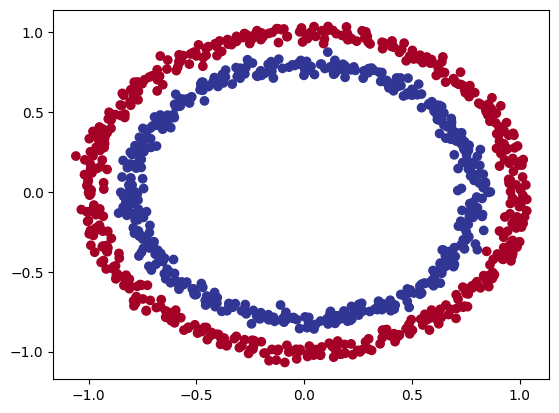

In [8]:
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

## Turn to tensors and apply train test split

In [9]:
type(X), X.dtype

(numpy.ndarray, dtype('float64'))

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape,y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

## Building the model

In [13]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
from torch import nn

In [15]:
# Constructing model

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()

    # Create 2 nn.Linear layers capable of handling the shape of data
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=1)


  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [16]:
next(model_0.parameters())

Parameter containing:
tensor([[-0.4389, -0.1327],
        [-0.4923,  0.6879],
        [ 0.1510, -0.0830],
        [ 0.5363,  0.1056],
        [-0.2340,  0.5979]], device='cuda:0', requires_grad=True)

In [17]:
model_0.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.4389, -0.1327],
                      [-0.4923,  0.6879],
                      [ 0.1510, -0.0830],
                      [ 0.5363,  0.1056],
                      [-0.2340,  0.5979]], device='cuda:0')),
             ('layer1.bias',
              tensor([0.4475, 0.2360, 0.1641, 0.4613, 0.5611], device='cuda:0')),
             ('layer2.weight',
              tensor([[ 0.0321,  0.0083, -0.4310,  0.3058,  0.3663]], device='cuda:0')),
             ('layer2.bias', tensor([0.3978], device='cuda:0'))])

In [18]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
model_0.state_dict()
# the first weight says --->2 inputs go to 5 different neurons
# the first bias says --->there are 5 neurons so there are the 5 bias
# the second weight says --->the last layer gets 5 inputs
# the second bias says --->the last layer has 1 neuron hence it has one bias

OrderedDict([('0.weight',
              tensor([[-0.0052,  0.5439],
                      [ 0.4719, -0.1607],
                      [-0.4148,  0.6277],
                      [ 0.2617,  0.6170],
                      [-0.3766,  0.6358]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6829, -0.4102, -0.0799,  0.3986, -0.0206], device='cuda:0')),
             ('1.weight',
              tensor([[-0.2556, -0.2034,  0.1375, -0.1222,  0.2849]], device='cuda:0')),
             ('1.bias', tensor([0.2019], device='cuda:0'))])

## Loss and Optimizer

In [20]:
loss_fn = nn.BCEWithLogitsLoss() # This has sigmoid activation function build in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


In [21]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)*100
  return acc

In [22]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))

y_logits

tensor([[0.5620],
        [0.4721],
        [0.5718],
        [0.5601],
        [0.2135],
        [0.1614],
        [0.1924],
        [0.1187],
        [0.5869],
        [0.4621],
        [0.5986],
        [0.5195],
        [0.1434],
        [0.5152],
        [0.6384],
        [0.1643],
        [0.3411],
        [0.6544],
        [0.6084],
        [0.6766],
        [0.4753],
        [0.0819],
        [0.6254],
        [0.6928],
        [0.2729],
        [0.1653],
        [0.3800],
        [0.0995],
        [0.6623],
        [0.4613],
        [0.2558],
        [0.2930],
        [0.5852],
        [0.3028],
        [0.6128],
        [0.4259],
        [0.5417],
        [0.5350],
        [0.3517],
        [0.4913],
        [0.6363],
        [0.6150],
        [0.3355],
        [0.1967],
        [0.5908],
        [0.4066],
        [0.1655],
        [0.4859],
        [0.4433],
        [0.1829],
        [0.5664],
        [0.5895],
        [0.1000],
        [0.2309],
        [0.2029],
        [0

In [23]:
# logits are direct output of the model
# we then apply sigmoid to get prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs[:5], torch.round(y_pred_probs[:5])

(tensor([[0.6369],
         [0.6159],
         [0.6392],
         [0.6365],
         [0.5532]], device='cuda:0'),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.]], device='cuda:0'))

## Training Loop

In [24]:
epochs = 250
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_0.train()
  # forward pass
  y_logits = model_0(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  # Loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds)

  # Optimizer zero grad
  optimizer.zero_grad

  # Backpropagation
  loss.backward()

  # Step
  optimizer.step()

  # Testing
  model_0.eval()
  with torch.inference_mode():
    # Testing forward pass
    test_logits = model_0(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    # Calc test loss
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

    if epoch%25==0:
      print(f"For epoch: {epoch}")
      print(f"Traing Loss: {loss:.5f} | Testing Loss: {test_loss:.5f}")
      print(f"Training accuracy: {acc:.2f} | Testing accuracy: {test_acc:.2f}")




For epoch: 0
Traing Loss: 0.71717 | Testing Loss: 0.71391
Training accuracy: 50.00 | Testing accuracy: 50.00
For epoch: 25
Traing Loss: 0.70170 | Testing Loss: 0.70198
Training accuracy: 51.38 | Testing accuracy: 50.00
For epoch: 50
Traing Loss: 0.69983 | Testing Loss: 0.70178
Training accuracy: 45.12 | Testing accuracy: 45.00
For epoch: 75
Traing Loss: 0.70644 | Testing Loss: 0.69991
Training accuracy: 48.62 | Testing accuracy: 50.00
For epoch: 100
Traing Loss: 0.70492 | Testing Loss: 0.70522
Training accuracy: 50.00 | Testing accuracy: 50.00
For epoch: 125
Traing Loss: 0.70450 | Testing Loss: 0.69397
Training accuracy: 40.88 | Testing accuracy: 49.00
For epoch: 150
Traing Loss: 0.70519 | Testing Loss: 0.72239
Training accuracy: 54.25 | Testing accuracy: 56.50
For epoch: 175
Traing Loss: 0.70771 | Testing Loss: 0.69772
Training accuracy: 52.88 | Testing accuracy: 52.50
For epoch: 200
Traing Loss: 0.69442 | Testing Loss: 0.69527
Training accuracy: 51.00 | Testing accuracy: 50.00
For ep

In [25]:
import requests
from pathlib import Path

In [26]:
# download helper functions from github repo if it doesnt exist
if Path('helper_functions.py').is_file():
  print("helper_functions.py file already exist, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py file already exist, skipping download


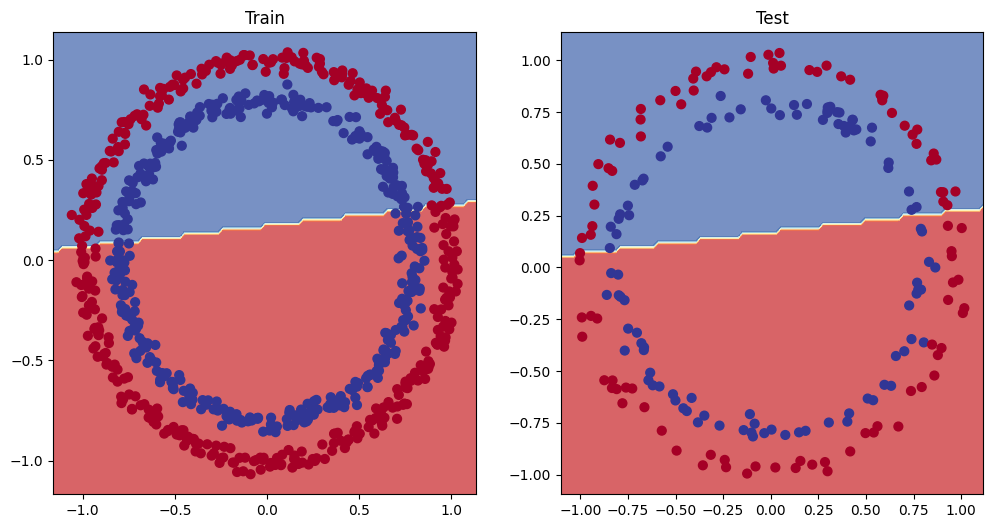

In [27]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# Final Model

In [74]:
n_samples = 1000

X, y = make_circles(n_samples,
                    random_state=42,
                    noise=0.03)

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [76]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [77]:
class MakeCircles(nn.Module):
  def __init__(self):
    super().__init__()

    self.linear_layer1 = nn.Linear(in_features=2, out_features=36)
    self.linear_layer2 = nn.Linear(in_features=36, out_features=36)
    self.linear_layer3 = nn.Linear(in_features=36, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.linear_layer3(self.relu(self.linear_layer2(self.relu(self.linear_layer1(x)))))

model = MakeCircles()
model = model.to(device)
model.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802],
                      [-0.3258, -0.0829],
                      [-0.2872,  0.4691],
                      [-0.5582, -0.3260],
                      [-0.1997, -0.4252],
                      [ 0.0667, -0.6984],
                      [ 0.6386, -0.6007],
                      [ 0.5459,  0.1177],
                      [-0.2296,  0.4370],
                      [ 0.1102,  0.5713],
                      [ 0.0773, -0.2230],
                      [ 0.1900, -0.1918],
                      [ 0.2976,  0.6313],
                      [ 0.4087, -0.309

In [78]:
next(model.parameters())

Parameter containing:
tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188],
        [ 0.6146,  0.1323],
        [ 0.5224,  0.0958],
        [ 0.3410, -0.0998],
        [ 0.5451,  0.1045],
        [-0.3301,  0.1802],
        [-0.3258, -0.0829],
        [-0.2872,  0.4691],
        [-0.5582, -0.3260],
        [-0.1997, -0.4252],
        [ 0.0667, -0.6984],
        [ 0.6386, -0.6007],
        [ 0.5459,  0.1177],
        [-0.2296,  0.4370],
        [ 0.1102,  0.5713],
        [ 0.0773, -0.2230],
        [ 0.1900, -0.1918],
        [ 0.2976,  0.6313],
        [ 0.4087, -0.3091],
        [ 0.4082,  0.1265],
        [ 0.3591, -0.4310],
        [-0.7000, -0.2732],
        [-0.5424,  0.5802],
        [ 0.2037,  0.2929],
        [ 0.2236, -0.0123],
        [ 0.5534, -0.5024],
        [ 0.0445, -0.4826],
        [ 0.2180, -0.2435],
        [ 0.2167, -0.1473],
        [ 0.5865, -0.4191],
        [-0.4217, -0.4217]

In [79]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=0.01)

In [80]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred)*100
  return acc

In [81]:
epochs = 100
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(epochs):

  model.train()
  y_logits = model(X_train).squeeze()
  y_preds_trained = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_preds_trained)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()

  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits)).squeeze()

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  if epoch%10==0:
    print(f"Epoch: {epoch}")
    print(f"Training Loss: {loss} | Test Loss: {test_loss}")
    print(f"Training accuracy: {acc} | Test accuracy: {test_acc}")

Epoch: 0
Training Loss: 0.6926668882369995 | Test Loss: 0.6890122890472412
Training accuracy: 64.125 | Test accuracy: 50.0
Epoch: 10
Training Loss: 0.6372519731521606 | Test Loss: 0.6335442066192627
Training accuracy: 77.875 | Test accuracy: 84.5
Epoch: 20
Training Loss: 0.46783941984176636 | Test Loss: 0.47382858395576477
Training accuracy: 99.75 | Test accuracy: 98.5
Epoch: 30
Training Loss: 0.22417090833187103 | Test Loss: 0.24875542521476746
Training accuracy: 99.75 | Test accuracy: 99.5
Epoch: 40
Training Loss: 0.07063900679349899 | Test Loss: 0.09221066534519196
Training accuracy: 100.0 | Test accuracy: 100.0
Epoch: 50
Training Loss: 0.023758763447403908 | Test Loss: 0.03796457126736641
Training accuracy: 100.0 | Test accuracy: 100.0
Epoch: 60
Training Loss: 0.011214532889425755 | Test Loss: 0.022873425856232643
Training accuracy: 100.0 | Test accuracy: 100.0
Epoch: 70
Training Loss: 0.006893005222082138 | Test Loss: 0.016493957489728928
Training accuracy: 100.0 | Test accuracy: 

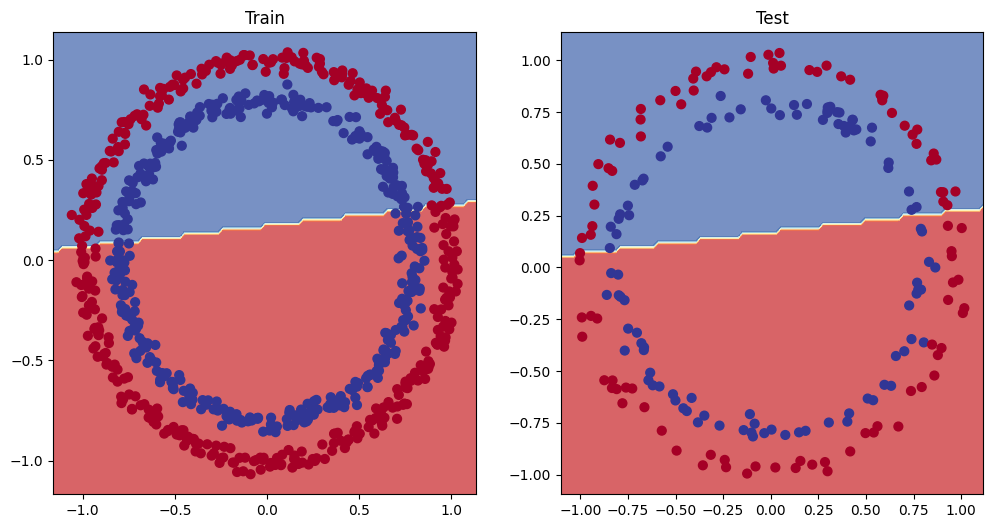

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

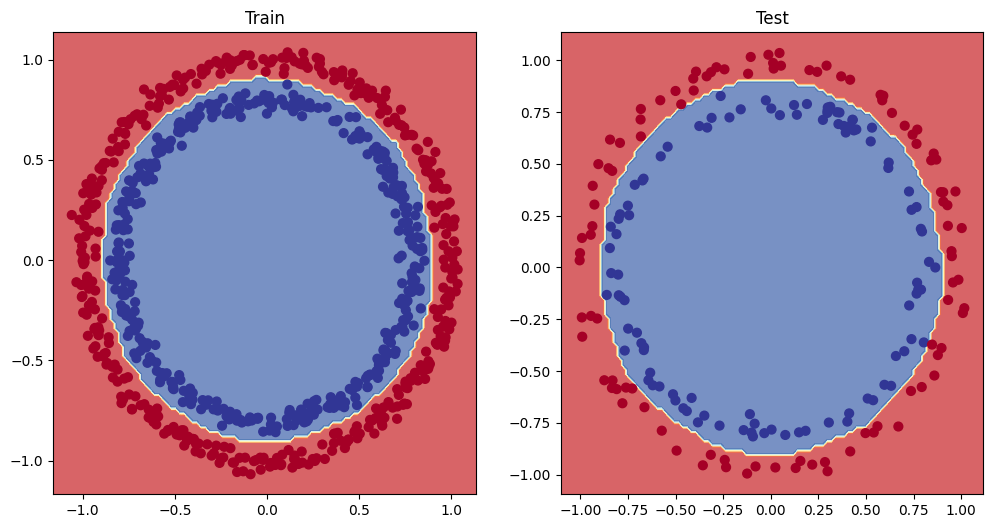

In [83]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)